# Classification model for Classifying Blood Cell

## Dataset Classes and info

|Cell Type   |Total Images by Type |Percentage (%)|
|------------|----------|---------------------|
|Neutrophils |3,329     | 19.48 |
|Eosinophils |3,117     | 18.24 |
|Basophils   |1,218     | 7.13  |
|Lymphocytes |1,214     | 7.10  |
|Monocytes   |1,420     | 8.31
|Immature Granulocytes | 2,895  | 16.94 | 
|Erythroblasts |1,551 | 9.07 | 
|Platelets (Thrombocytes) |2,348 | 13.74 |
|Total |17,092 | 100 |


In [32]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.functional import log_softmax, softmax
import torchvision
import torchvision.transforms.functional as F
from torchvision import transforms
import torchmetrics
from torchsummary import summary

from IPython.display import display

import lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import Callback, ModelCheckpoint, EarlyStopping
from lightning.pytorch.callbacks.progress import TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Global seed set to 4179


In [33]:
ALL_DATA = np.load("./bloodmnist lorez.npz")

In [34]:
print(ALL_DATA)
for k in ALL_DATA.files:
    print(k)

NpzFile './bloodmnist lorez.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...
train_images
train_labels
val_images
val_labels
test_images
test_labels


In [35]:
train_images = ALL_DATA["train_images"]
train_labels = ALL_DATA["train_labels"].flatten()
val_images = ALL_DATA["val_images"]
val_labels = ALL_DATA["val_labels"].flatten()
test_images = ALL_DATA["test_images"]
test_labels = ALL_DATA["test_labels"].flatten()

class_names = ['Neutrophils', 'Eosinophils', 'Basophils', 'Lymphocytes', 'Monocytes', 'Immature Granulocytes', 'Erythroblasts', 'Platelets (Thrombocytes)']
num_classes = 8

In [36]:
print(train_labels)

[7 3 6 ... 1 6 4]


In [37]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally (left to right)
    transforms.RandomRotation(10), # Apply a random rotation up to 10 degrees to each image
    transforms.RandomResizedCrop((28,28), ratio=(0.8, 1.2), scale=(0.75, 1)), # Added to v8 training set
    transforms.Normalize(0.5, 0.5) # Normalize pixel values to have a mean and standard deviation of 0.5
])


val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5) # Normalize pixel values to have a mean and standard deviation of 0.5
])

## Create Dataset

In [38]:
class BloodCellDataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels

        self.transform = transform

    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):

        images = self.images[idx]
        if (self.transform != None):
            images = self.transform(images)

        return images, self.labels[idx]

In [39]:
trainset = BloodCellDataset(train_images, train_labels, train_transforms)
valset = BloodCellDataset(val_images, val_labels, val_test_transforms)
testset = BloodCellDataset(test_images, test_labels, val_test_transforms)

In [40]:
img, lab = trainset[1]
print(img.shape)

torch.Size([3, 28, 28])


In [41]:
BATCH_SIZE = 32 # Define batch size

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)  # Training data loader with shuffling
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)     # Validation data loader without shuffling
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)   # Test data loader without shuffling

print('Batch shape for each loader\n---------------------------')
images, labels = next(iter(trainloader))
print(f'trainloader\t: {images.shape}')
images, labels = next(iter(valloader))
print(f'valloader  \t: {images.shape}')
images, labels = next(iter(testloader))
print(f'testloader \t: {images.shape}')

Batch shape for each loader
---------------------------
trainloader	: torch.Size([32, 3, 28, 28])
valloader  	: torch.Size([32, 3, 28, 28])
testloader 	: torch.Size([32, 3, 28, 28])


train set


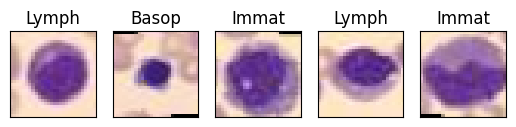

val set


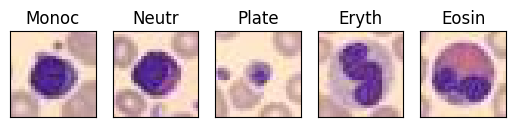

test set


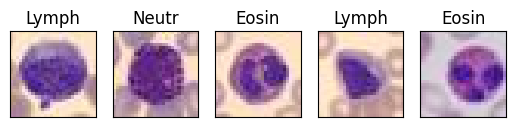

In [42]:
# Write a function to visualize images from a given data loader 
# Note: Use titles to denote class label in words.
def visualize_dataloader(dataloader, class_names):
    
    # Create a figure with subplots to display images
    plt.figure()

    # Get a batch of images and labels from the data loader
    images, labels = next(iter(dataloader))

    # Loop through the first 5 images in the batch
    for i in range(5):
        image = images[i].squeeze() * 0.5 + 0.5  # Un-normalize the image
        image = image.permute(1, 2, 0)
        label = labels[i]  # Get the label for the image

        # Display the image in the subplot
        plt.subplot(1, 5, i+1, title=class_names[label][:5])
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

    # Show the plot with the images and labels
    plt.show()
    
# visualize images from the trainloader
print('train set')
visualize_dataloader(trainloader, class_names)

# visualize images from the valloader
print('val set')
visualize_dataloader(valloader, class_names)

# visualize images from the valloader
print('test set')
visualize_dataloader(testloader, class_names)

## Model Architecture

In [43]:
class MyCNN(pl.LightningModule):
    
    def __init__(self, num_classes):
        super().__init__()

        self.epochs = 200
        self.lr = 1e-3
        self.logdir = "BloodCellClassification"

        self.loss = nn.CrossEntropyLoss()

        self.sequence1 = nn.Sequential( # Input: (28 x 28) -> output(14 x 14)
            nn.Conv2d(3, 64, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Dropout(0.3)
        )

        self.sequence2 = nn.Sequential( # Input
            nn.Conv2d(64, 64, 3, padding=1), # Padding = 3 #TODO: try 64
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),
            nn.Dropout(0.3)
        )

        self.sequence3 = nn.Sequential(
            nn.Conv2d(64, 16, 7, padding = 1), # Padding = 2 used in v7, max acc: 
            nn.Tanh(), # Might create some contrast? 
            nn.Dropout(0.3)
        )

        self.sequence4 = nn.Sequential(
            # nn.Conv2d(32, 16, 3), # Padding = 3 - realised this is homogenising everything to one value
            # # Padding = 1 used in v7, ngl no help
            # nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)) # Version 2 has 16*16
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*4*4, 128), # Version 2 has 16*16*16
            nn.Tanh(),
            nn.Linear(128, num_classes),
        )

        
        # Define metrics for Train, Val and Test
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)



    def forward(self, x):
        x = self.sequence1(x)
        x = self.sequence2(x)
        x = self.sequence3(x)
        x = self.sequence4(x)
        x = self.fc(x)   
        return x



    def training_step(self, batch, batch_idx):
        # Define logic for training step
        images, labels = batch
        logits = self(images)

        loss = self.loss(logits, labels)

        preds = logits.argmax(1)
        self.train_accuracy.update(preds, labels)

        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return loss
    


    def validation_step(self, batch, batch_idx):
        # Define logic for validation step
        images, labels = batch
        logits = self(images)

        loss = self.loss(logits, labels)

        preds = logits.argmax(1)
        self.val_accuracy.update(preds, labels)

        
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return logits



    def test_step(self, batch, batch_idx):
        # Define logic for test step
        images, labels = batch
        logits = self(images)

        loss = self.loss(logits, labels)

        preds = logits.argmax(1)
        self.test_accuracy.update(preds, labels)

        
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        return logits
        


    def predict_step(self, batch, batch_idx):
        images, labels = batch

        return [self(images), labels, images] # Return predicted class, actual class, and input 



    def configure_optimizers(self):
        # Configure optimizers and schedulers
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        return optimizer



    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        return trainloader

    def val_dataloader(self):
        return valloader

    def test_dataloader(self):
        return testloader

In [44]:
model = MyCNN(num_classes=num_classes)

# print summary of the model to double check
# summary(task3_model.to('cuda'), (1, 48,48)) # delete .to('cuda') if not using cpu
summary(model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,792
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
           Dropout-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
              ReLU-6           [-1, 64, 14, 14]               0
         MaxPool2d-7             [-1, 64, 7, 7]               0
           Dropout-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 16, 3, 3]          50,192
             Tanh-10             [-1, 16, 3, 3]               0
          Dropout-11             [-1, 16, 3, 3]               0
AdaptiveAvgPool2d-12             [-1, 16, 4, 4]               0
          Flatten-13                  [-1, 256]               0
           Linear-14                  [

In [ ]:
# # Define checkpoint callback function to save the model at the best epoch
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    save_top_k=1,        # save the best model based on validation accuracy
    mode="max",
    every_n_epochs=1,
)

In [ ]:
trainer = pl.Trainer(
    accelerator="auto",
    devices=1  if not torch.cuda.is_available() else torch.cuda.device_count(),
    max_epochs=model.epochs,
    callbacks=[TQDMProgressBar(refresh_rate=20)],
    logger= CSVLogger(save_dir=model.logdir),
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [47]:
# Call pl.Trainer and put in the relevant arguments

trainer.fit(model)


  | Name           | Type               | Params
------------------------------------------------------
0 | loss           | CrossEntropyLoss   | 0     
1 | sequence1      | Sequential         | 1.8 K 
2 | sequence2      | Sequential         | 36.9 K
3 | sequence3      | Sequential         | 50.2 K
4 | sequence4      | Sequential         | 0     
5 | fc             | Sequential         | 33.9 K
6 | train_accuracy | MulticlassAccuracy | 0     
7 | val_accuracy   | MulticlassAccuracy | 0     
8 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\trainer\call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [63]:
model.lr = 1e-4
trainer.fit(model)

c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory BloodCellClassification\lightning_logs\version_0\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name           | Type               | Params
------------------------------------------------------
0 | loss           | CrossEntropyLoss   | 0     
1 | sequence1      | Sequential         | 1.8 K 
2 | sequence2      | Sequential         | 36.9 K
3 | sequence3      | Sequential         | 50.2 K
4 | sequence4      | Sequential         | 0     
5 | fc             | Sequential         | 33.9 K
6 | train_accuracy | MulticlassAccuracy | 0     
7 | val_accuracy   | MulticlassAccuracy | 0     
8 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total esti

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [64]:
trainer.test(model) 

c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9573224186897278     │
│         test_loss         │    0.13109973073005676    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.13109973073005676, 'test_acc': 0.9573224186897278}]

## Read Logs

In [65]:
print("Reading " + trainer.logger.log_dir + "/metrics.csv")
metricspath = trainer.logger.log_dir + "\\metrics.csv"
# metricspath = model_path + "\\metrics.csv"
metrics = pd.read_csv(metricspath )
metrics.set_index("epoch", inplace=True)
metrics = metrics.groupby(level=0).sum().drop("step", axis=1) 

Reading BloodCellClassification\lightning_logs\version_0/metrics.csv


## Plot Training Losses and Accuracies

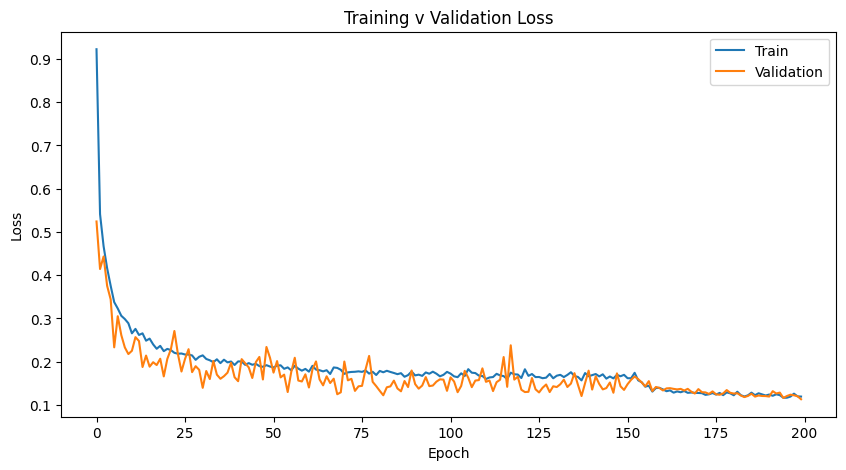

In [66]:
# Create a figure with all the appropriate labels/titles etc.
plt.figure(figsize=(10, 5))

plt.plot(metrics["train_loss"][:-1])
plt.plot(metrics["val_loss"][:-1])
plt.title("Training v Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
_ = plt.legend(["Train","Validation"])

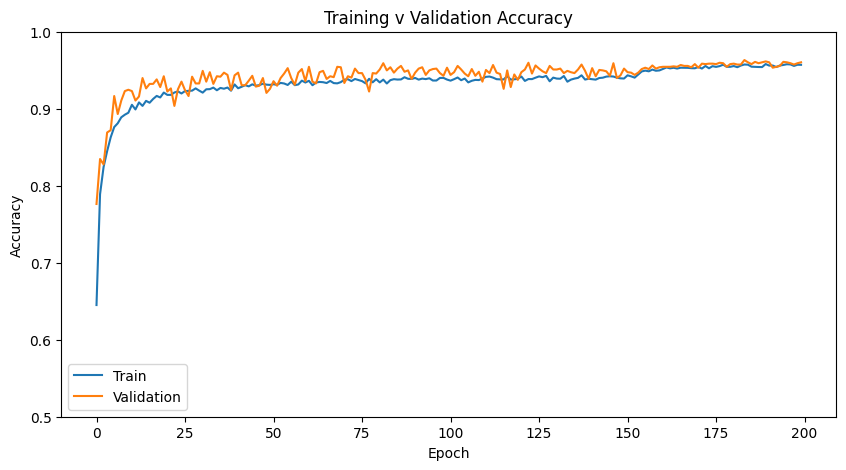

In [67]:
# Create a figure with all the appropriate labels/titles etc.
plt.figure(figsize=(10, 5))

plt.plot(metrics["train_acc"][:-1])
plt.plot(metrics["val_acc"][:-1])
plt.title("Training v Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.ylim([0.5, 1])

_ = plt.legend(["Train","Validation"])



## Get predictions for assessment

In [68]:
## These are the predictions for the test set. You will use this for the tasks below during the analysis process.

predictions = trainer.predict(model, testloader) # do not do anything to the variable 'predictions' you will reuse it

test_outputs = torch.concat([prediction[0] for prediction in predictions], dim=0)
test_labels = torch.concat([prediction[1] for prediction in predictions], dim=0)
test_inputs = torch.concat([prediction[2] for prediction in predictions], dim=0)
test_preds = test_outputs.argmax(dim=1) # Get the predicted lables

c:\Users\keren\.conda\envs\AI\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

## Confusion matrix

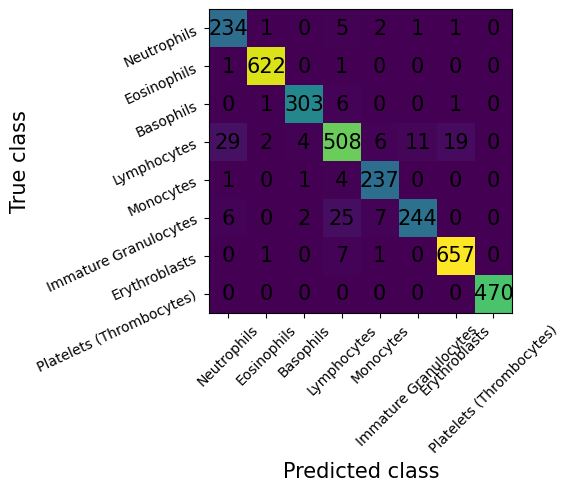

In [69]:
# Plot the confusion matrix
# You can create a ConfusionMatrix instance for multiclass classification with 'num_classes' from the lightning library

confusion_mat = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
confusion_mat.update(test_preds, test_labels)
fig_, ax_ = confusion_mat.plot(labels=class_names)

## Top Misclassed

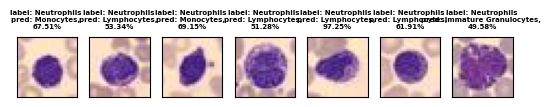

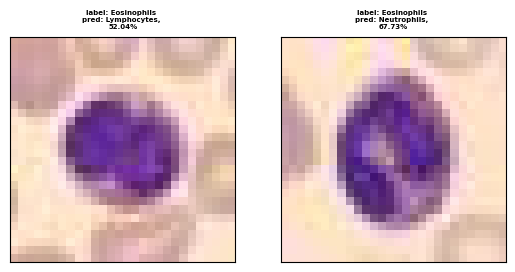

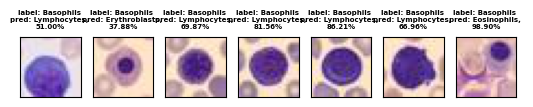

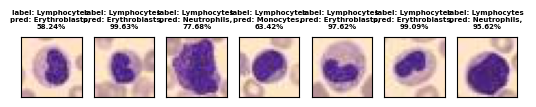

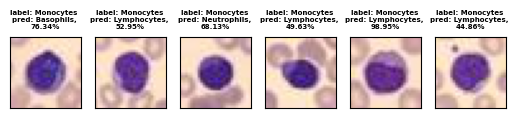

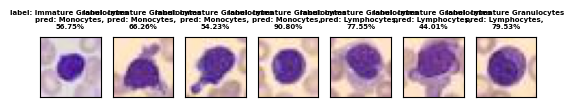

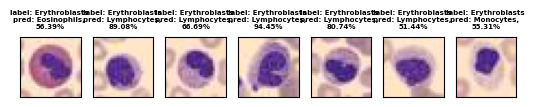

<Figure size 640x480 with 0 Axes>

In [70]:
# Loop through each class (category)
incorrect = test_preds.not_equal(test_labels)

for c in range(num_classes):
    # Get the indexes of the incorrectly identified in the class
    incorrect_log = incorrect.logical_and(test_labels.eq(c))
    incorrect_c_indexes = incorrect_log.nonzero()

    
    k = int(min(7, torch.sum(incorrect_log)))

    # Get the correlated outputs for each index
    filtered = test_outputs[incorrect_log]
    # Find the prediction level for each
    confidences, _ = torch.softmax(filtered, dim=1).max(dim=1)
    # Get the top k confidences and their indexes in confidences
    vls, conf_indexes = torch.topk(confidences, k)
    # Get their indexes in the original unfiltered results
    indexes = incorrect_c_indexes[conf_indexes].reshape(-1)

    # Create a figure with subplots to display images
    plt.figure()

    # Loop through the first 5 images in the batch
    for i in range(k):
        
        image = test_inputs[indexes[i]] * 0.5 + 0.5  # Un-normalize the image
        image = image.permute(1, 2, 0)
        label = test_labels[indexes[i]]# Get the label for the image
        pred = test_preds[indexes[i]]
        confidence = confidences[i]
        # Display the image in the subplot
        ax = plt.subplot(1, k, i+1)
        ax.set_title(f"label: {class_names[label] } \npred: {class_names[pred]}, \n{confidence.max().item()*100:.2f}%",fontweight="bold", size=5) # Title
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])

    # Show the plot with the images and labels
    plt.show()

## Feature Maps

In [71]:
# You will be defining the visualize_features function here
# Where you will visualize the features at different convolutional layers
# To see what "features" is as an input, we recommend looking at the comments in the next code cell
# so that you can understand what the shape of the feature map is after passing the image through the convolutional layers and activation functions

def visualize_features(features):
    # Determine the number of feature maps
    # Determine the maximum and minimum values within each feature map so you can normalize the plot of the features according to these values
    num_fmaps = features.shape[0] # Number of feature maps in each layer
    num_cols = 8 # We always have divisible powers of 8 for the number of channels in the conv layers
    num_rows = 16
    fmax = features.max() # Max values of features
    fmin = features.min() # Min values of features

    # Create the figures of the feature maps
    # Create a figure with subplots to display images
    plt.figure(figsize=(12,12))
    # Loop through the first 5 images in the batch
    for i in range(num_fmaps):
        
        image = features[i].detach().numpy() # Un-normalize the image

        # Display the image in the subplot
        plt.subplot(num_rows, num_cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(image)

    # Show the plot with the images and labels
    plt.show()

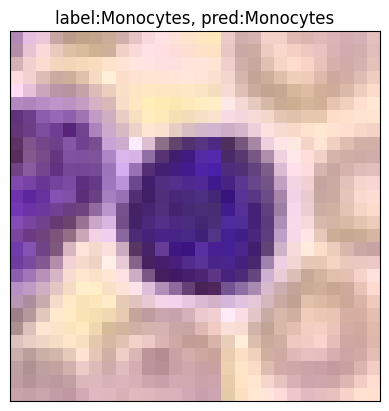

In [72]:
# Find indices of correctly classified test samples
idxs = torch.nonzero((test_labels == test_preds), as_tuple=False)

# Select a random index from the correctly classified samples
idx = idxs[random.randrange(0,len(idxs))]

# Retrieve the image, true label, model output, predicted label for the selected index
image = test_inputs[idx]
pred = test_preds[idx]
output = test_outputs[idx]
label = test_labels[idx]

# Create a figure with subplots to display images
plt.figure()


disp_image = image.squeeze().permute(1,2,0) * 0.5 + 0.5  # Un-normalize the image


# Display the image in the subplot
plt.title("label:" + class_names[label] + ", pred:" + class_names[pred])
plt.imshow(disp_image)
plt.xticks([])
plt.yticks([])

# Show the plot with the images and labels
plt.show()


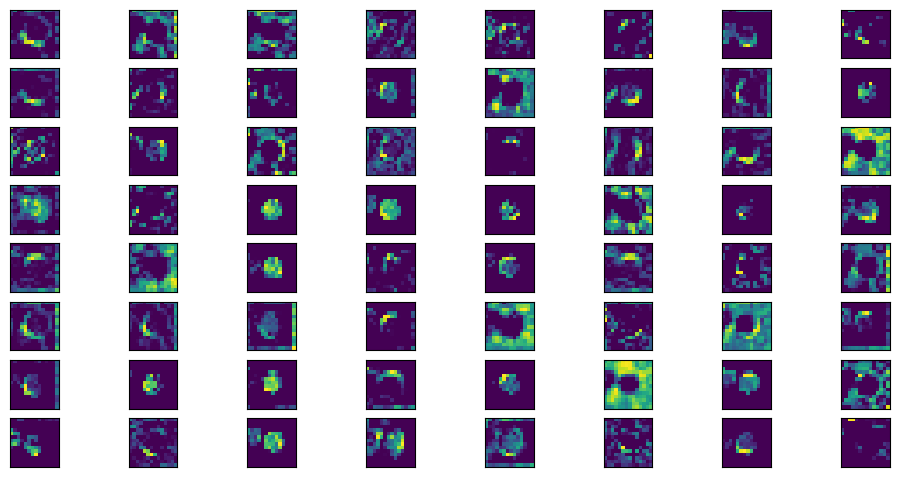

In [73]:
image = model.sequence1(image[0])
visualize_features(image)

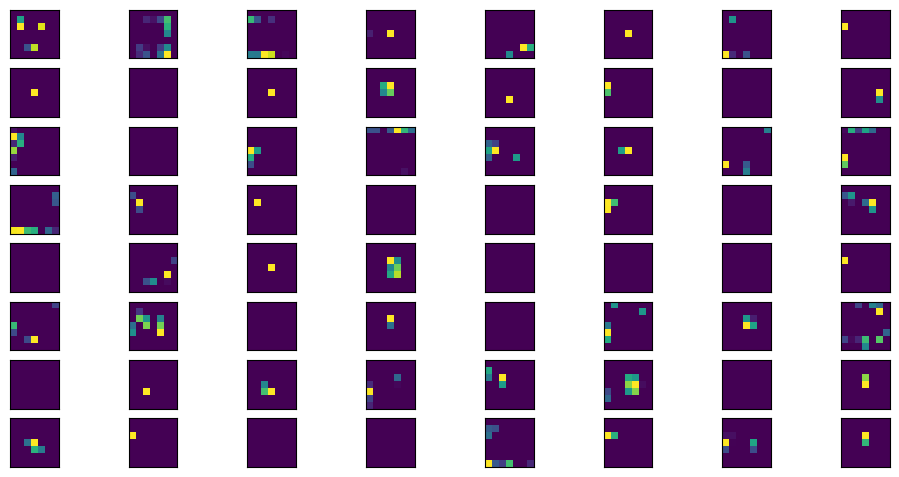

In [74]:
image = model.sequence2(image)
visualize_features(image)

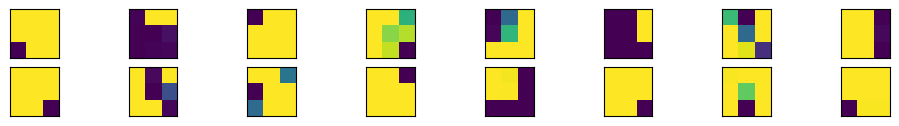

In [75]:
image = model.sequence3(image)
visualize_features(image)

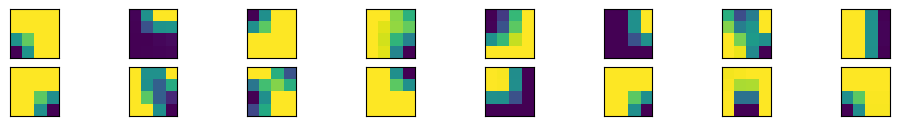

In [76]:
image = model.sequence4(image)
visualize_features(image)

## Saliency Map

tensor([2664])


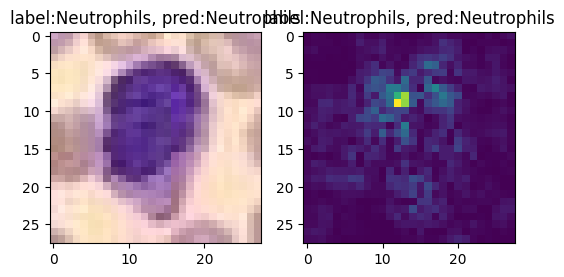

In [77]:
# Find indices of correctly classified test samples
test_correct_idx = (test_preds == test_labels).logical_and(test_labels == 0).nonzero()

# Select a random index from the correctly classified samples
idx = test_correct_idx[random.randrange(0,len(test_correct_idx))]
print(idx)

# Retrieve the input image, true label, model output, predicted label for the selected index
image = test_inputs[idx]
pred = test_preds[idx]
output = test_outputs[idx]
label = test_labels[idx]


# Add a batch dimension to the input image (via .unsqueeze()) and set requires_grad to True for saliency analysis
# image = image.unsqueeze(0)
image.requires_grad = True

# Compute the scores and gradients for the input image
# To compute the scores, do a forward pass of the image and then take the argmax
# Use this index to extract the score_max value from "scores"
# Then perform a backward step so that it backpropagates the gradient
scores = model(image)
score_max_index = torch.argmax(scores)
score_max = scores[0, score_max_index]
score_max.backward() # Do the backward step here for the gradient calculation

# Calculate the saliency map by finding the absolute gradient values across channels
map = image.grad.data.abs()

# Create a subplot to display the original image and saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Display the original image with proper unnormalization
# Do this in the first subplot

disp_image = image.squeeze().permute(1, 2, 0).detach().numpy() * 0.5 + 0.5  # Un-normalize the image

# Display the image in the subplot
plt.subplot(1,2, 1)
plt.title("label:" + class_names[label] + ", pred:" + class_names[pred])
plt.imshow(disp_image)

# Display the saliency map
# Do this in the second subplot
map = map[0][0]

map_max, _ = map.max(1)
map_min, _ = map.min(1)

map_max, _ = map_max.max(0)
map_min, _ = map_min.min(0)


disp_image = torch.sigmoid(((map- map_min)/(map_max-map_min)))

# Display the image in the subplot
plt.subplot(1,2,2)
plt.title("label:" + class_names[label] + ", pred:" + class_names[pred])
plt.imshow(disp_image)

# Show the original image and saliency map side by side
plt.show()